# Common statistical tests are linear models (or: how to teach stats)

Original post by Jonas Kristoffer Lindeløv ([blog](https://lindeloev.net), [profile](http://personprofil.aau.dk/117060)). Python port by George Ho ([blog](https://eigenfoo.xyz)).

In [1]:
from datetime import datetime
from IPython.display import display, Markdown
import utils
display(Markdown("Last updated: {}".format(datetime.now().strftime("%B %d, %Y"))))
display(Markdown(utils.generate_toc()))

Last updated: June 25, 2019

# Table of contents
- [Common statistical tests are linear models (or: how to teach stats)](#Common-statistical-tests-are-linear-models-(or:-how-to-teach-stats))
- [1 The simplicity underlying common tests](#1-The-simplicity-underlying-common-tests)
- [2 Settings and toy data](#2-Settings-and-toy-data)
- [3 Pearson and Spearman correlation](#3-Pearson-and-Spearman-correlation)
    - [3.0.1 Theory: As linear models](#3.0.1-Theory:-As-linear-models)
    - [3.0.2 Theory: rank-transformation](#3.0.2-Theory:-rank-transformation)
    - [3.0.3 Python code: Pearson correlation](#3.0.3-Python-code:-Pearson-correlation)
    - [3.0.4 Python code: Spearman correlation](#3.0.4-Python-code:-Spearman-correlation)
- [4 One mean](#4-One-mean)
  - [4.1 One sample $t$-test and Wilcoxon signed-rank](#4.1-One-sample-$t$-test-and-Wilcoxon-signed-rank)
    - [4.1.1 Theory: As linear models](#4.1.1-Theory:-As-linear-models)
    - [4.1.2 Python code: One-sample $t$-test](#4.1.2-Python-code:-One-sample-$t$-test)
    - [4.1.3 Python code: Wilcoxon signed-rank test](#4.1.3-Python-code:-Wilcoxon-signed-rank-test)
  - [4.2 Paired samples $t$-test and Wilcoxon matched pairs](#4.2-Paired-samples-$t$-test-and-Wilcoxon-matched-pairs)
    - [4.2.1 Theory: As linear models](#4.2.1-Theory:-As-linear-models)
    - [4.2.2 Python code: Paired sample $t$-test](#4.2.2-Python-code:-Paired-sample-$t$-test)
    - [4.2.3 Python code: Wilcoxon matched pairs](#4.2.3-Python-code:-Wilcoxon-matched-pairs)
- [5 Two means](#5-Two-means)
  - [5.1 Independent t-test and Mann-Whitney U](#5.1-Independent-t-test-and-Mann-Whitney-U)
    - [5.1.1 Theory: As linear models](#5.1.1-Theory:-As-linear-models)
    - [5.1.2 Theory: Dummy coding](#5.1.2-Theory:-Dummy-coding)
    - [5.1.3 Theory: Dummy coding (continued)](#5.1.3-Theory:-Dummy-coding-(continued))
    - [5.1.4 Python code: independent t-test](#5.1.4-Python-code:-independent-t-test)
    - [5.1.5 Python code: Mann-Whitney U](#5.1.5-Python-code:-Mann-Whitney-U)
  - [5.2 Welch’s t-test](#5.2-Welch’s-t-test)

This document is summarised in the table below. It shows the linear models underlying common parametric and "non-parametric" tests. Formulating all the tests in the same language highlights the many similarities between them. Get it [as an image](linear_tests_cheat_sheet.png) or [as a PDF](linear_tests_cheat_sheet.pdf).

---

[![](linear_tests_cheat_sheet.png)](linear_tests_cheat_sheet.pdf)

---

# 1 The simplicity underlying common tests

Most of the common statistical models ($t$-test, correlation, ANOVA, chi-square, etc.) are special cases of linear models, or a very close approximation. This beautiful simplicity means that there is less to learn. In particular, it all comes down to $y = a \cdot x + b$ which most students know from high school. Unfortunately, introductory statistics courses are usually taught as if each test is an independent tool, needlessly making life more complicated for students and teachers alike. 

This needless complexity multiplies when students try to rote learn the parametric assumptions underlying each test separately rather than deducing them from the linear model.

For this reason, I think that teaching linear models first and foremost and *then* name-dropping the special cases along the way makes for an excellent teaching strategy, emphasizing *understanding* over rote learning. Since linear models are the same across frequentist, Bayesian, and permutation-based inferences, I'd argue that it's better to start with modeling than p-values, type-1 errors, Bayes factors, or other inferences.

Concerning the teaching of *"non-parametric"* tests in intro-courses, I think that we can justify [lying-to-children](https://en.wikipedia.org/wiki/Lie-to-children) and teach "non-parametric"" tests as if they are merely ranked versions of the corresponding parametric tests. It is much better for students to think "ranks!" than to believe that you can magically throw away assumptions. Indeed, the Bayesian equivalents of "non-parametric"" tests implemented in [JASP](https://jasp-stats.org) [literally just do (latent) ranking](https://arxiv.org/abs/1712.06941) and that's it. For the frequentist "non-parametric"" tests considered here, this approach is highly accurate for N > 15.

Use the menu to jump to your favourite section. There are links to lots of similar (though more scattered) stuff under [sources](#links) and [teaching materials](#course). I hope that you will join in suggesting improvements or submitting improvements yourself in [the Github repo to this page](https://github.com/lindeloev/tests-as-linear). Let's make it awesome!

# 2 Settings and toy data

In [2]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import plots
np.random.seed(1618)  # Reproducible results
plt.style.use('seaborn-whitegrid')

In [3]:
# Correlated data with fixed correlation
correlated_data = pd.DataFrame()
correlated_data["x"] = np.random.normal(0.5, 0.5, 20)
correlated_data["y"] = 0.9 * correlated_data["x"] + 0.2 + 0.1*np.random.randn(20)

correlated_data.head()

,x,y
0,-0.290010,-0.084340
1,0.917701,1.039325
2,0.817674,0.899141
3,0.089775,0.335860
4,0.300801,0.467720


In [4]:
data = pd.DataFrame()
data["x"] = np.random.normal(loc=0.0, scale=1.0, size=50)  # Used in correlation where this is on x-axis
data["y"] = np.random.normal(loc=0.5, scale=1.0, size=50)  # Almost zero mean
data["y2"] = np.random.normal(loc=0.8, scale=1.0, size=50)  # Used in two means
data["y_sub_y2"] = data["y"] - data["y2"]

data.head()

,x,y,y2,y_sub_y2
0,0.370360,0.934343,0.188027,0.746316
1,-1.403470,-0.256456,-0.004594,-0.251862
2,0.006593,0.116555,0.516582,-0.400027
3,-1.242953,0.025103,0.494504,-0.469401
4,-0.504203,-0.339618,1.753154,-2.092772


# 3 Pearson and Spearman correlation

### 3.0.1 Theory: As linear models 

Model: the recipe for $y$ is a slope ($\beta_1$) times $x$ plus an intercept ($\beta_0$, aka a straight line).

$y = \beta_0 + \beta_1 x \qquad \mathcal{H}_0: \beta_1 = 0$

... which is a math-y way of writing the good old $y = ax + b$ (here ordered as $y = b + ax$). Using `patsy` lets us be a bit lazier and write `y ~ 1 + x` which reads like `y = 1*number + x*othernumber`. and the task of linear models is simply to find the numbers that best predict `y`.

Either way you write it, it's an intercept ($\beta_0$) and a slope ($\beta_1$) yielding a straight line:

In [5]:
res = smf.ols(formula="y ~ 1 + x", data=correlated_data).fit()
intercept, slope = res.params

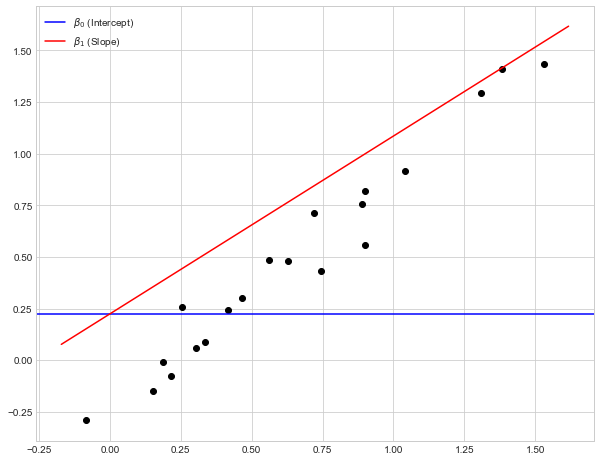

In [6]:
plots.linear_regression_plot(correlated_data, intercept, slope)
plt.show()

This is often simply called a **regression** model which can be extended to **multiple regression** where there are several $\beta$s and on the right-hand side multiplied with the predictors. Everything below, from [one-sample $t$-test](#t1) to [two-way ANOVA](#anova2) are just special cases of this system. Nothing more, nothing less.

As the name implies, the **Spearman rank correlation** is a **Pearson correlation** on rank-transformed $x$ and $y$:

$\text{rank}(y) = \beta_0 + \beta_1 \cdot \text{rank}(x) \qquad \mathcal{H}_0: \beta_1 = 0$

I'll introduce [ranks](#Theory:-rank-transformation) in a minute. For now, notice that the correlation coefficient of the linear model is identical to a "real" Pearson correlation, but p-values are an approximation which is is [appropriate for samples greater than N=10 and almost perfect when N > 20](simulations/simulate_spearman.html).

Such a nice and non-mysterious equivalence that many students are left unaware of! Visualizing them side by side including data labels, we see this rank-transformation in action:

In [7]:
ranked_data = np.argsort(np.abs(correlated_data), axis=0) + 1
res = smf.ols(formula="y ~ 1 + x", data=ranked_data).fit()
intercept_spearman, slope_spearman = res.params

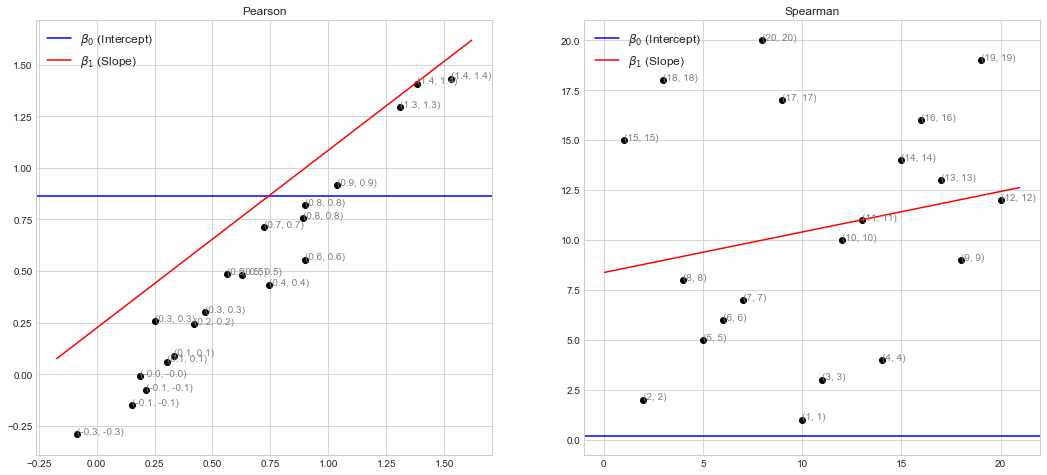

In [8]:
plots.pearson_spearman_plot(correlated_data, ranked_data, slope, slope_spearman, intercept, intercept_spearman)
plt.show()

### 3.0.2 Theory: rank-transformation

`scipy.stats.rankdata` simply takes a list of numbers and "replaces" them with the integers of their rank (1st smallest, 2nd smallest, 3rd smallest, etc.). So the result of the rank-transformation `scipy.stats.rankdata([3.6, 3.4, -5.0, 8.2])` is `[3, 2, 1, 4]`. See that in the figure above? 

A _signed_ rank is the same, just where we rank according to absolute size first and then add in the sign second. So the signed rank here would be `[2, 1, -3, 4]`. Or in code:

In [9]:
def signed_rank(df):
    return np.sign(df) * df.abs().rank()

I hope I don't offend anyone when I say that ranks are easy; yet it's all you need to do to convert most parametric tests into their "non-parametric" counterparts! One interesting implication is that *many "non-parametric tests" are about as parametric as their parametric counterparts with means, standard deviations, homogeneity of variance, etc. - just on rank-transformed data*. That's why I put "non-parametric" in quotation marks.

### 3.0.3 Python code: Pearson correlation

It couldn't be much simpler to run these models with `statsmodels` ([`smf.ols`](https://www.statsmodels.org/stable/example_formulas.html#ols-regression-using-formulas)) or `scipy` ([`scipy.stats.pearson`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)). They yield identical slopes, `p` and `t` values, but there's a catch: `smf.ols` gives you the *slope* and even though that is usually much more interpretable and informative than the _correlation coefficient_ $r$, you may still want $r$. Luckily, the slope becomes $r$ if `x` and `y` have a standard deviation of exactly 1. You can do this by scaling the data: `data /= data.std()`.

In [10]:
scaled_data = correlated_data / correlated_data.std()

res1 = smf.ols(formula="y ~ 1 + x", data=correlated_data).fit()
res2 = smf.ols(formula="y ~ 1 + x", data=scaled_data).fit()
r, p = scipy.stats.pearsonr(correlated_data["x"], correlated_data["y"])

In [11]:
utils.tabulate_results([r, p, None, None, None],
                       [res1, res2],
                       ["scipy.stats.pearsonr", "smf.ols", "smf.ols (scaled)"])

,value,p-values,t-values,0.025 CI,0.975 CI
scipy.stats.pearsonr,0.981042,2.804604e-14,NaN,NaN,NaN
smf.ols,0.861270,2.804604e-14,21.47749,0.777021,0.945520
smf.ols (scaled),0.981042,2.804604e-14,21.47749,0.885077,1.077008


Notice how scipy.stats and smf.ols (scaled) have the same values.

### 3.0.4 Python code: Spearman correlation

Note that we can interpret the slope which is the number of ranks $y$ change for each rank on $x$. I think that this is a pretty interesting number. However, the intercept is less interpretable since it lies at $\text{rank}(x) = 0$ which is impossible since x starts at 1.

See the identical `r` (now "rho") and `p`:

In [12]:
ranked_data = np.argsort(correlated_data, axis=0)

res = smf.ols(formula="y ~ 1 + x", data=ranked_data).fit()
r, p = scipy.stats.spearmanr(ranked_data["x"], ranked_data["y"])

In [13]:
utils.tabulate_results([r, p, None, None, None],
                       res,
                       ["scipy.stats.spearmanr", "smf.ols (ranked)"])

,value,p-values,t-values,0.025 CI,0.975 CI
scipy.stats.spearmanr,0.566917,0.009146,NaN,NaN,NaN
smf.ols (ranked),0.566917,0.009146,2.919762,0.158991,0.974844


# 4 One mean

## 4.1 One sample $t$-test and Wilcoxon signed-rank

### 4.1.1 Theory: As linear models

**$t$-test** model: A single number predicts $y$.

$y = \beta_0 \qquad \mathcal{H}_0: \beta_0 = 0$

In other words, it's our good old $y = \beta_0 + \beta_1*x$ where the last term is gone since there is no $x$ (essentially $x=0$, see left figure below).

The same is to a very close approximately true for **Wilcoxon signed-rank test**, just with the [signed ranks](#rank) of $y$ instead of $y$ itself (see right panel below).

$\text{signed_rank}(y) = \beta_0$

[This approximation is good enough when the sample size is larger than 14 and almost perfect if the sample size is larger than 50](simulations/simulate_wilcoxon.html).

In [14]:
signed_rank_correlated_data = signed_rank(correlated_data)
res = smf.ols(formula="y ~ 1", data=signed_rank_correlated_data).fit()
intercept_wilcoxon = res.params.Intercept

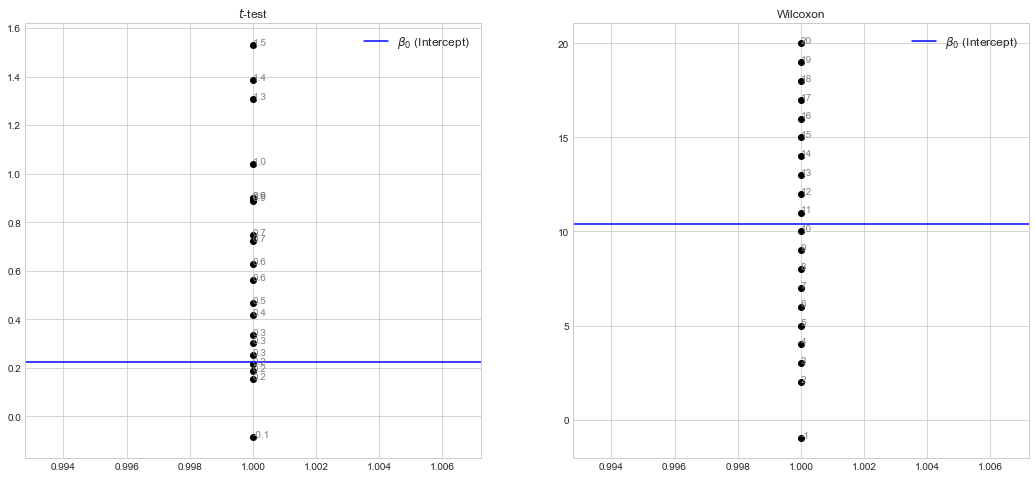

In [15]:
plots.ttest_wilcoxon_plot(correlated_data, intercept, intercept_wilcoxon)
plt.show()

### 4.1.2 Python code: One-sample $t$-test

Try running the R code below and see that the linear model (`lm`) produces the same $t$, $p$, and $r$ as the built-in `t.test`. The confidence interval is not presented in the output of `lm` but is also identical if you use `confint(lm(...))`:

In [16]:
t, p = scipy.stats.ttest_1samp(data.y, 0)
res = smf.ols(formula="y ~ 1", data=data).fit()  # Equivalent linear model: intercept-only

In [17]:
utils.tabulate_results([None, p, t, None, None],
                       res,
                       ["scipy.stats.ttest_1samp", "smf.ols (y ~ 1)"],
                       x=False)

,value,p-values,t-values,0.025 CI,0.975 CI
scipy.stats.ttest_1samp,NaN,0.01806,2.446494,NaN,NaN
smf.ols (y ~ 1),0.319429,0.01806,2.446494,0.057047,0.581811


### 4.1.3 Python code: Wilcoxon signed-rank test

In addition to matching `p`-values, `lm` also gives us the mean signed rank, which I find to be an informative number.

In [18]:
signed_rank_data = signed_rank(data)

_, p = scipy.stats.wilcoxon(data.y)
res = smf.ols("y ~ 1", data=signed_rank_data).fit()

In [19]:
utils.tabulate_results([None, p, None, None, None],
                       res,
                       ["scipy.stats.wilcoxon", "smf.ols (y ~ 1, signed rank)"],
                       x=False)

,value,p-values,t-values,0.025 CI,0.975 CI
scipy.stats.wilcoxon,NaN,0.032500,NaN,NaN,NaN
"smf.ols (y ~ 1, signed rank)",8.86,0.031028,2.220672,0.842229,16.877771


## 4.2 Paired samples $t$-test and Wilcoxon matched pairs

### 4.2.1 Theory: As linear models

**$t$-test** model: a single number (intercept) predicts the pairwise differences.

$y_2-y_1 = \beta_0 \qquad \mathcal{H}_0: \beta_0 = 0$

This means that there is just one $y = y_2 - y_1$ to predict and it becomes a [one-sample $t$-test](#t1) on the pairwise differences. The visualization is therefore also the same as for the one-sample $t$-test. At the risk of overcomplicating a simple substraction, you can think of these pairwise differences as slopes (see left panel of the figure), which we can represent as y-offsets (see right panel of the figure):

In [20]:
res = smf.ols(formula="y_sub_y2 ~ 1", data=data).fit()
intercept_wilcoxon = res.params.Intercept

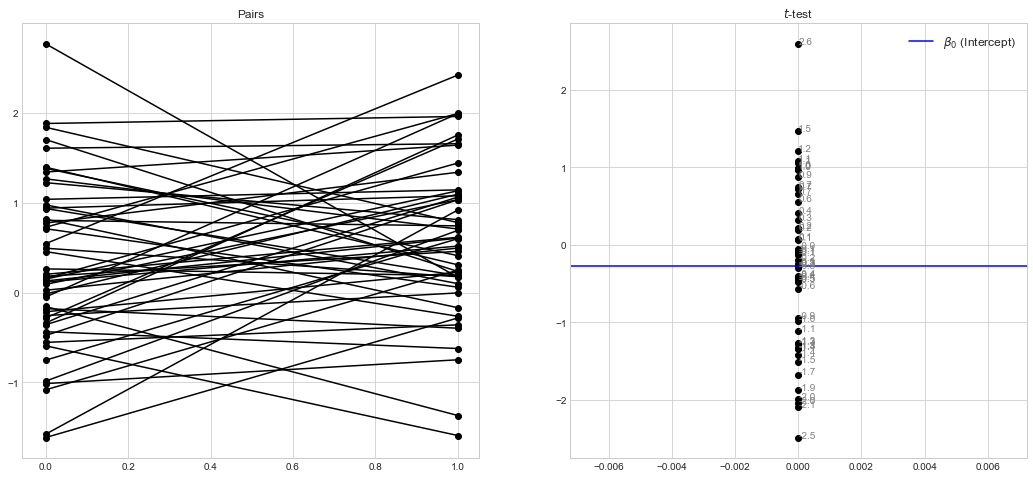

In [21]:
plots.pairs_wilcoxon_plot(data, intercept_wilcoxon)
plt.show()

Similarly, the **Wilcoxon matched pairs** only differ from **Wilcoxon signed-rank** in that it's testing the signed ranks of the pairwise $y_2-y_1$ differences.

$\text{signed_rank}(y_2-y_1) = \beta_0 \qquad \mathcal{H}_0: \beta_0 = 0$

### 4.2.2 Python code: Paired sample $t$-test

In [22]:
t, p = scipy.stats.ttest_rel(data.y, data.y2)
res = smf.ols(formula="y_sub_y2 ~ 1", data=data).fit()

In [23]:
utils.tabulate_results([None, p, t, None, None],
                       res,
                       ["scipy.stats.ttest_ind", "smf.ols (y_sub_y2 ~ 1)"],
                       x=False)

,value,p-values,t-values,0.025 CI,0.975 CI
scipy.stats.ttest_ind,NaN,0.075029,-1.818975,NaN,NaN
smf.ols (y_sub_y2 ~ 1),-0.278406,0.075029,-1.818975,-0.585985,0.029173


### 4.2.3 Python code: Wilcoxon matched pairs

Again, we do the signed-ranks trick. This is still an approximation, but a close one:

In [24]:
_, p = scipy.stats.wilcoxon(data.y, data.y2)
res = smf.ols(formula="y_sub_y2 ~ 1", data=signed_rank_data).fit()

In [25]:
utils.tabulate_results([None, p, None, None, None],
                       res,
                       ["scipy.stats.wilcoxon", "smf.ols (y_sub_y2 ~ 1)"],
                       x=False)

,value,p-values,t-values,0.025 CI,0.975 CI
scipy.stats.wilcoxon,NaN,0.071808,NaN,NaN,NaN
smf.ols (y_sub_y2 ~ 1),-7.46,0.071386,-1.842978,-15.594353,0.674353


For large sample sizes (N >> 100), this approaches the **sign test** to a reasonable degree, but this approximation is too inaccurate to flesh out here.

# 5 Two means

## 5.1 Independent t-test and Mann-Whitney U

### 5.1.1 Theory: As linear models

Independent t-test model: two means predict $y$.

$y_i = \beta_0 + \beta_1 x_i \qquad \mathcal{H}_0: \beta_1 = 0$

where $x_i$ is an indicator (0 or 1) saying whether data point $i$ was sampled from one or the other group. [Indicator variables (also called "dummy coding")](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)) underly a lot of linear models and we'll take an aside to see how it works in a minute.

**Mann-Whitney U** (also known as **Wilcoxon rank-sum test** for two independent groups; no *signed* rank this time) is the same model to a very close approximation, just on the ranks of $x$ and $y$ instead of the actual values:

$\text{rank}(y_i) = \beta_0 + \beta_1 x_i \qquad \mathcal{H}_0: \beta_1 = 0$

To me, equivalences like this make "non-parametric" statistics much easier to understand. The approximation is appropriate [when the sample size is larger than 11 in each group and virtually perfect when N > 30 in each group](simulations/simulate_mannwhitney.html).

### 5.1.2 Theory: Dummy coding

Dummy coding can be understood visually. The indicator is on the x-axis so data points from the first group are located at $x = 0$ and data points from the second group is located at $x = 1$. Then $\beta_0$ is the intercept (blue line) and $\beta_1$ is the slope between the two means (red line). Why? Because when $\Delta x = 1$ the slope equals the difference because:

$\text{slope} = \Delta y / \Delta x = \Delta y / 1 = \Delta y = \text{difference}$

Magic! Even categorical differences can be modelled using linear models! It's a true Swiss army knife.

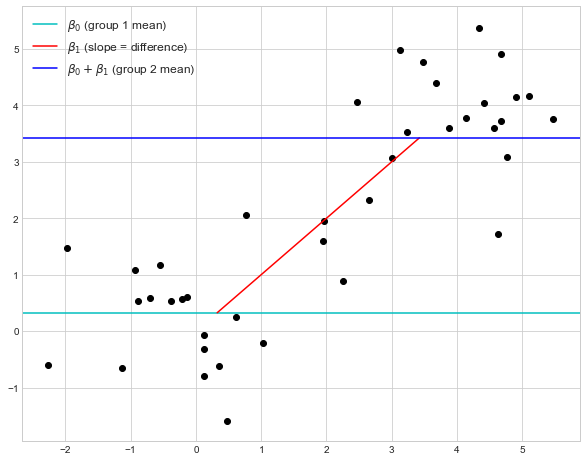

In [26]:
plots.dummy_coding_plot()
plt.show()

### 5.1.3 Theory: Dummy coding (continued)

If you feel like you get dummy coding now, just skip ahead to the next section. Here is a more elaborate explanation of dummy coding:

If a data point was sampled from the first group, i.e., when $x_i = 0$, the model simply becomes $y = \beta_0 + \beta_1 \cdot 0 = \beta_0$. In other words, the model predicts that that data point is $beta_0$. It turns out that the $\beta$ which best predicts a set of data points is the *mean* of those data points, so $\beta_0$ is the mean of group 1.

On the other hand, data points sampled from the second group would have $x_i = 1$ so the model becomes $y_i = \beta_0 + \beta_1\cdot 1 = \beta_0 + \beta_1$. In other words, we add $\beta_1$ to "shift" from the mean of the first group to the mean of the second group. Thus $\beta_1$ becomes the *mean difference* between the groups.

As an example, say group 1 is 25 years old ($\beta_0 = 25$) and group 2 is 28 years old ($\beta_1 = 3$), then the model for a person in group 1 is $y = 25 + 3 \cdot 0 = 25$ and the model for a person in group 2 is $y = 25 + 3 \cdot 1 = 28$. 

Hooray, it works! For first-timers it takes a few moments to understand dummy coding, but you only need to know addition and multiplication to get there!

### 5.1.4 Python code: independent t-test

As a reminder, when we write `y ~ 1 + x` in R, it is shorthand for $y = \beta_0 \cdot 1 + \beta_1 \cdot x$ and R goes on computing the $\beta$s for you. Thus `y ~ 1 + x` is the R-way of writing $y = a \cdot x + b$.

Notice the identical `t`, `df`, `p`, and estimates. We can get the confidence interval by running `confint(lm(...))`.

In [27]:
# TODO

### 5.1.5 Python code: Mann-Whitney U

In [28]:
# TODO

## 5.2 Welch’s t-test

This is identical to the (Student's) [independent t-test](#t2) above except that Student's assumes identical variances and **Welch's t-test** does not. So the linear model is the same and the trick is in the variances, which I won't go further into here.

In [29]:
t, p = scipy.stats.ttest_ind(data.y, data.y2, equal_var=False)